# Семантическая Сегментация. Часть 1.

Функциональный U-NET на Keras

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import random
import imageio
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

## Загрузка данных
`me_256.png` - Изображение

`me_gt_256.png` - Карта сагментации (человек/фон)

In [3]:
if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png

--2021-10-12 20:12:27--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118993 (116K) [image/png]
Saving to: ‘me_256.png’

me_256.png          100%[===================>] 116.20K  --.-KB/s    in 0.02s   

2021-10-12 20:12:27 (5.63 MB/s) - ‘me_256.png’ saved [118993/118993]

--2021-10-12 20:12:27--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2

## Визуализация данных

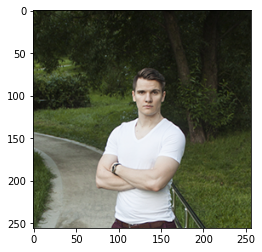

In [5]:
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

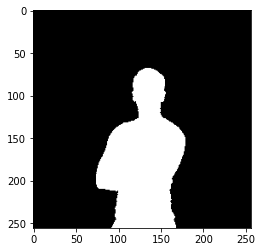

In [6]:
gt = imageio.imread('me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_=plt.imshow(gt[...,0], cmap='gray')

## Создание "игрушечного" сегментационного датасета
Датасет очень маленький, модель скорее всего переобучится.
Наша цель - проверить работоспособность пайплайна.

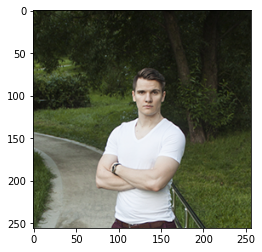

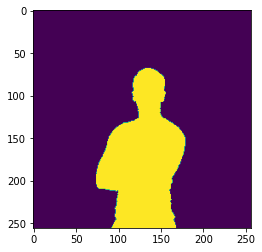

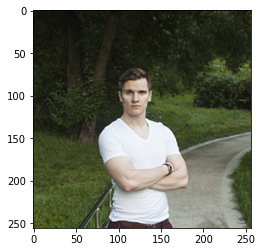

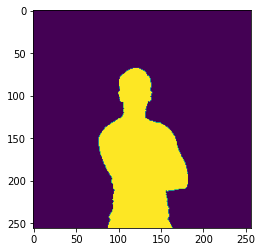

(<matplotlib.image.AxesImage at 0x7f3c57277590>, None)

In [9]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

## Создание модели U-Net

In [10]:
# U-Net(очень похожая модель, но идейно похожа на нее)
# Функциональный метод построение сетей в TF
def build_model():
    x = tf.keras.layers.Input((256, 256, 3)) # входной размер картинки(для некоторых архитектура можно использовать None вместо размера)
    
    # Дальше применяем свертку, понимать это стоит так: Создаем слой и сразу вызываем его для входных данных - х
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # Тут необходимо назвать по другому, чтобы результат потом пробросить в конец сети для конкатенации
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    # Транспонированная свертка(увеличение картинки сверткой)
    # Увеличиваем пространственные размерности страйдом (2,2)
    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    # Skip connection
    # Проброс информации о картинки пучем конкатенации, об этом говорилось ранее. Конкатенируем по 3тьему измерению(канальному)
    out = tf.concat([out4, out], axis=3)
    # Далее снова передаем в свертки
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    # Затем опять повышаем разрешение
    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    # На выходе имеем 1 канал в выходной карте признаком. Тоесть каждый пиксель будет иметь вероятность принадлежности к классам фон/человек
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    # Теперь просто передадим наш граф в керас
    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

## Визуализация U-Net

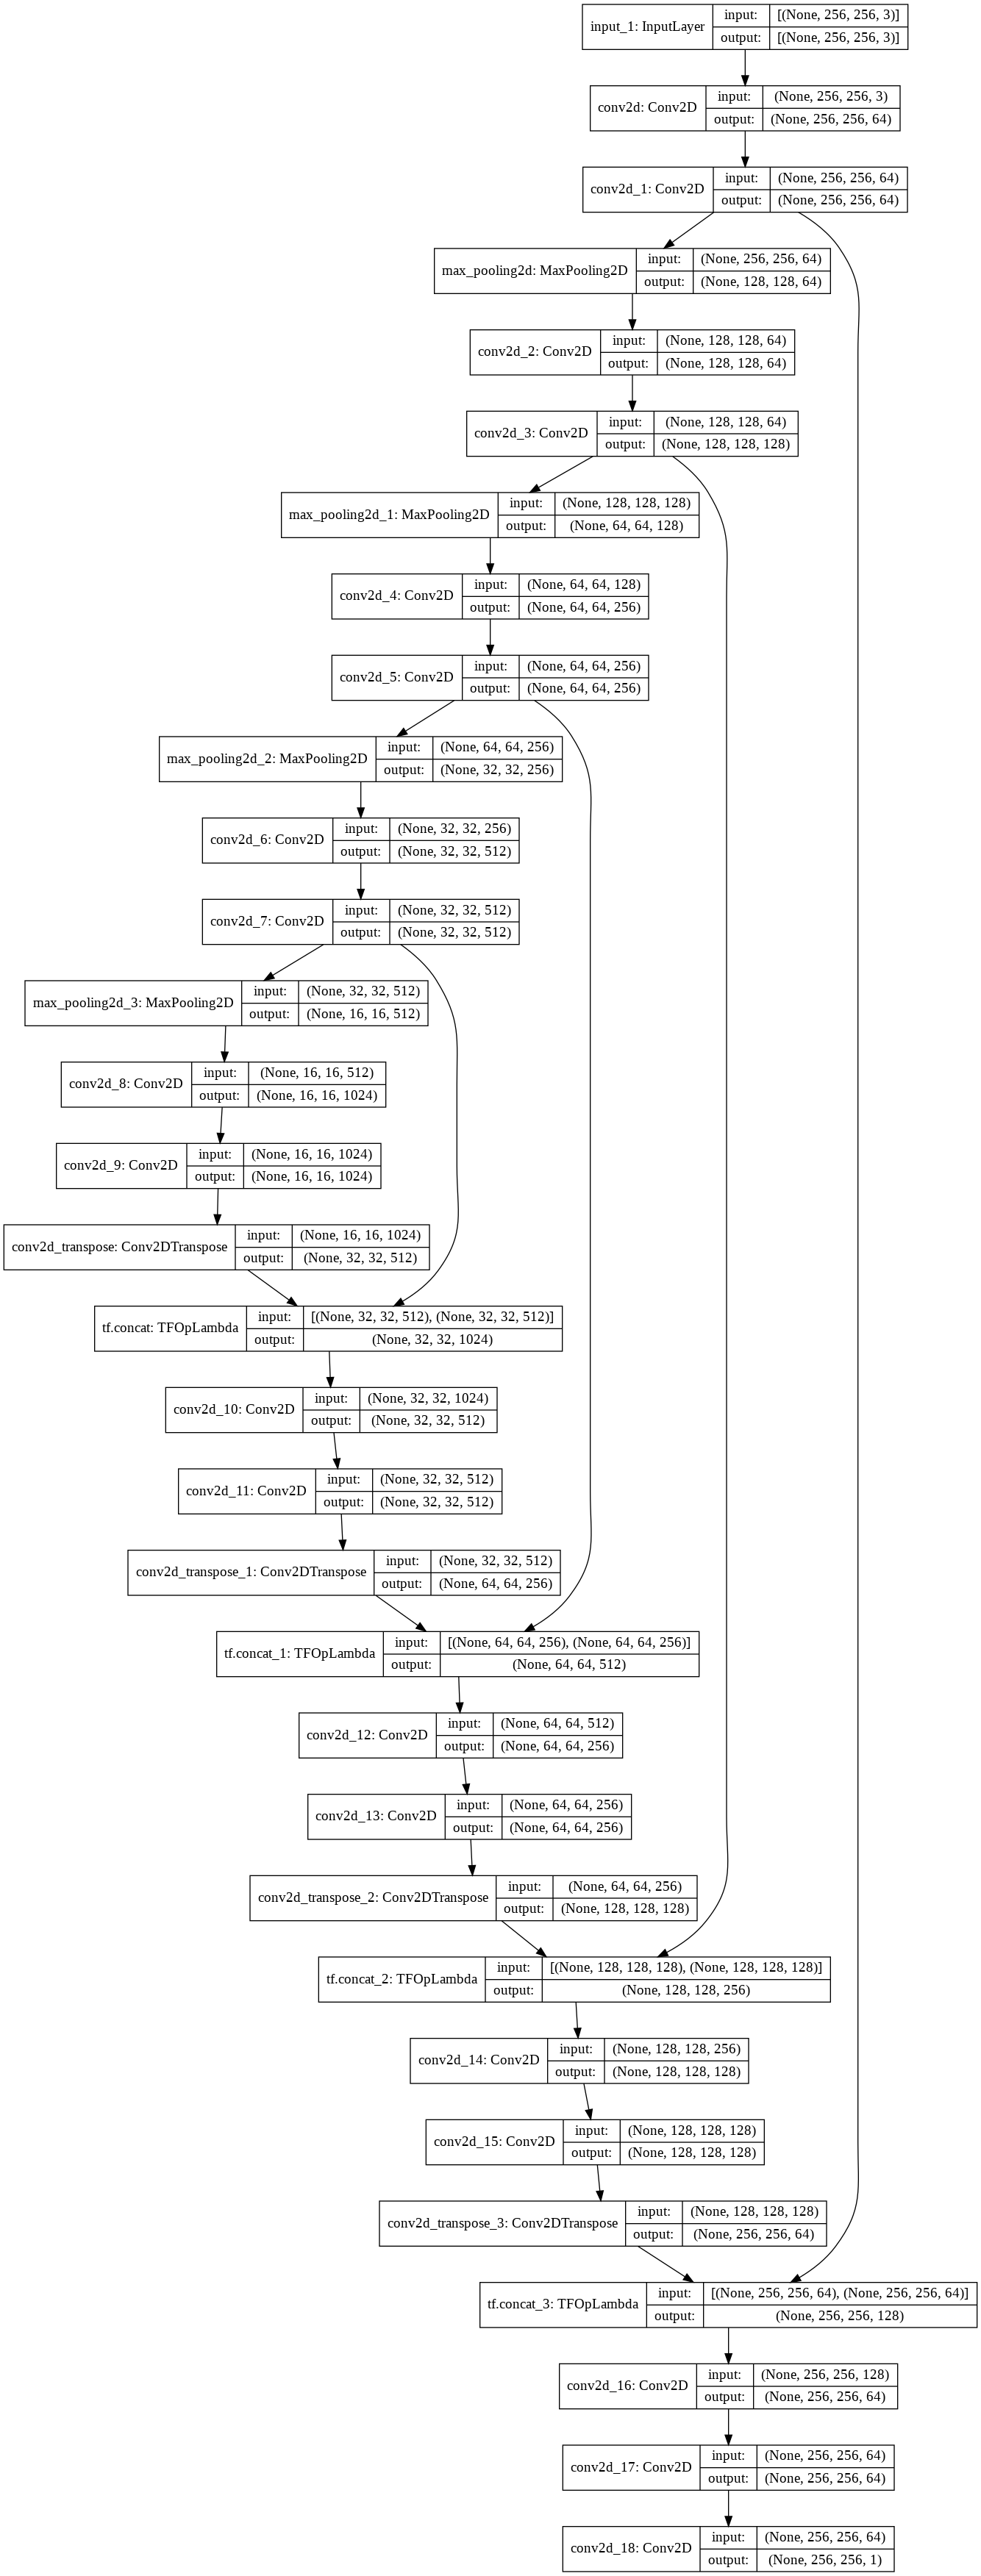

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение модели

Epoch 1/100
2/2 [==============================] - 35s 273ms/step - loss: 0.6900
Epoch 2/100
2/2 [==============================] - 1s 280ms/step - loss: 0.6688
Epoch 3/100
2/2 [==============================] - 1s 279ms/step - loss: 0.5871
Epoch 4/100
2/2 [==============================] - 1s 278ms/step - loss: 0.3314
Epoch 5/100
2/2 [==============================] - 1s 276ms/step - loss: 0.6549
Epoch 6/100
2/2 [==============================] - 1s 280ms/step - loss: 0.9417
Epoch 7/100
2/2 [==============================] - 1s 278ms/step - loss: 0.6746
Epoch 8/100
2/2 [==============================] - 1s 270ms/step - loss: 0.6606
Epoch 9/100
2/2 [==============================] - 1s 277ms/step - loss: 0.6339
Epoch 10/100
2/2 [==============================] - 1s 276ms/step - loss: 0.6015
Epoch 11/100
2/2 [==============================] - 1s 274ms/step - loss: 0.5709
Epoch 12/100
2/2 [==============================] - 1s 276ms/step - loss: 0.5390
Epoch 13/100
2/2 [==================

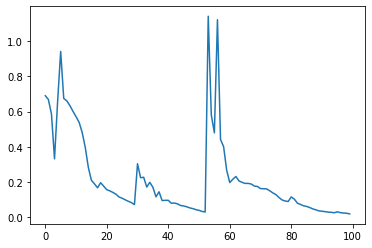

In [12]:
NUM_EPOCHS = 100
BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

## Пример результата сегментации

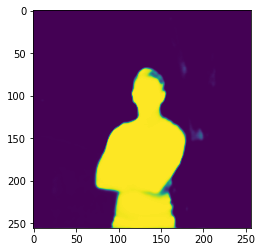

In [13]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

## Наложение карты сегментации на изображение

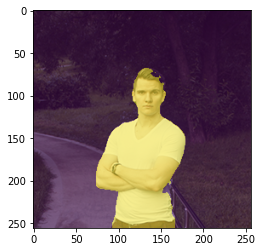

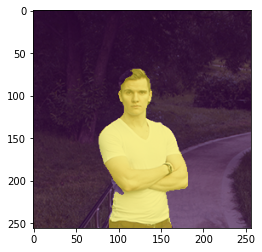

In [14]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()